In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost with one-hot NAICS Clusters (NN Embed)
XGBoost model, one hot encoded values from k means clustering

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

##### Get loans data, append clusters

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
sba_loans.filter(like='NAICS').columns

Index(['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc', 'NAICS_num',
       'menc_NAICS', 'cenc_NAICS'],
      dtype='object')

In [8]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('60_DATA_embeddings_tsne_naics.parquet'))

In [9]:
clus_cols = [c for c in embed_df if c.startswith('NC__')]
len(clus_cols)

10

In [10]:
sba_loans = sba_loans.drop(columns = clus_cols, errors='ignore') \
    .merge(embed_df[clus_cols + ['NAICS_orig']].rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

In [11]:
sba_loans[clus_cols].describe()

,NC__0.0,NC__1.0,NC__2.0,NC__3.0,NC__4.0,NC__5.0,NC__6.0,NC__7.0,NC__8.0,NC__9.0
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.065322,0.082980,0.156245,0.044983,0.050587,0.016056,0.050464,0.027798,0.151261,0.259738
std,0.247094,0.275852,0.363087,0.207267,0.219153,0.125692,0.218900,0.164393,0.358304,0.438491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [13]:
train_df.shape

(436120, 65)

#### Set the predictor features.  Include one-hot NAICS

In [14]:
predictor_features = setup.predictor_features + clus_cols
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'NC__0.0', 'NC__1.0', 'NC__2.0', 'NC__3.0', 'NC__4.0', 'NC__5.0', 'NC__6.0', 'NC__7.0', 'NC__8.0', 'NC__9.0']


In [15]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NC__0.0,NC__1.0,NC__2.0,NC__3.0,NC__4.0,NC__5.0,NC__6.0,NC__7.0,NC__8.0,NC__9.0,target
NoEmp,1.000000,0.062158,-0.013926,0.095658,-0.041427,0.001610,0.006409,-0.016303,0.008755,-0.001148,0.000191,0.009203,0.013392,0.016727,-0.004171,0.002985,-0.013320,-0.027403
CreateJob,0.062158,1.000000,-0.062740,0.134686,0.039302,0.009062,0.050517,-0.008838,0.003010,-0.004286,-0.012730,0.006490,-0.002643,-0.000138,-0.012637,0.025527,-0.005862,-0.010002
LowDoc,-0.013926,-0.062740,1.000000,-0.133141,0.153034,-0.120001,0.040841,-0.049313,0.007011,0.011771,0.011230,-0.012102,0.004369,0.007204,-0.005771,-0.016235,0.025323,-0.079523
DisbursementGross,0.095658,0.134686,-0.133141,1.000000,-0.065443,-0.007016,0.085712,-0.068602,0.039203,0.034044,0.037285,0.145826,0.043900,0.015714,0.048301,-0.039799,-0.112463,-0.120788
new_business,-0.041427,0.039302,0.153034,-0.065443,1.000000,-0.047592,0.137325,-0.005291,-0.024386,-0.010386,0.004285,-0.028791,-0.018141,-0.033602,-0.015115,0.023212,0.048799,0.013878
urban_flag,0.001610,0.009062,-0.120001,-0.007016,-0.047592,1.000000,-0.006588,0.022199,0.018198,-0.002799,-0.037050,-0.018612,-0.014210,-0.014147,-0.005308,0.019373,-0.001896,0.053785
franchise_flag,0.006409,0.050517,0.040841,0.085712,0.137325,-0.006588,1.000000,-0.010759,-0.044642,0.002873,-0.045845,0.033828,-0.017579,-0.035818,-0.041060,0.005895,0.071212,-0.012731
NC__0.0,-0.016303,-0.008838,-0.049313,-0.068602,-0.005291,0.022199,-0.010759,1.000000,-0.088696,-0.127609,-0.063534,-0.067700,-0.037360,-0.067795,-0.049722,-0.124879,-0.176719,0.127974
NC__1.0,0.008755,0.003010,0.007011,0.039203,-0.024386,0.018198,-0.044642,-0.088696,1.000000,-0.145549,-0.072466,-0.077218,-0.042613,-0.077326,-0.056712,-0.142436,-0.201564,-0.052553
NC__2.0,-0.001148,-0.004286,0.011771,0.034044,-0.010386,-0.002799,0.002873,-0.127609,-0.145549,1.000000,-0.104258,-0.111096,-0.061308,-0.111251,-0.081593,-0.204926,-0.289995,-0.026948


In [16]:
with open(Path(setup.temp_path).joinpath('61_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [17]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [18]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [19]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators)

In [20]:
xgb_model = xgb_model.set_params(**xgb_params)

In [21]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50050	validation_1-logloss:0.50414
[1]	validation_0-logloss:0.49314	validation_1-logloss:0.49707
[2]	validation_0-logloss:0.48698	validation_1-logloss:0.49120
[3]	validation_0-logloss:0.48180	validation_1-logloss:0.48628
[4]	validation_0-logloss:0.47737	validation_1-logloss:0.48209
[5]	validation_0-logloss:0.47371	validation_1-logloss:0.47860
[6]	validation_0-logloss:0.47058	validation_1-logloss:0.47562
[7]	validation_0-logloss:0.46796	validation_1-logloss:0.47310
[8]	validation_0-logloss:0.46567	validation_1-logloss:0.47097
[9]	validation_0-logloss:0.46343	validation_1-logloss:0.46882
[10]	validation_0-logloss:0.46177	validation_1-logloss:0.46726
[11]	validation_0-logloss:0.46011	validation_1-logloss:0.46576
[12]	validation_0-logloss:0.45858	validation_1-logloss:0.46430
[13]	validation_0-logloss:0.45729	validation_1-logloss:0.46311
[14]	validation_0-logloss:0.45615	validation_1-logloss:0.46207
[15]	validation_0-logloss:0.45528	validation_1-logloss:0.46129
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### Save the model

In [22]:
xgb_model.save_model(Path(setup.temp_path).joinpath('61_MODEL_xgboost.json'))

In [23]:
with open(Path(setup.temp_path).joinpath('61_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [24]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [25]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.181000,0.112334,0.016411,0.678323,0.167873
1,0.275525,0.107056,0.016411,0.678323,0.281272


## Decision Threshold
Max f1, on training data

In [26]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [27]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [28]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('61_REPORT_thresh_tune.csv'), index=False)

In [29]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.454443
11,0.22,0.453857


##### Apply decision threshold
All datasets

In [30]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [31]:
pred_df['predict_bin'].value_counts()

predict_bin
0    418219
1    269862
Name: count, dtype: int64

In [32]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('61_DATA_combined_predictions.parquet'))

## Metrics

In [33]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('61_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.717407,0.392975,0.339182,0.467047,0.352366,0.719498,NaN
1,train,0.654324,0.454443,0.335626,0.703487,0.387077,0.734097,NaN
2,val,0.650662,0.450618,0.334432,0.690511,0.379610,0.725422,NaN
0,test,0.649307,0.448602,0.331518,0.693544,0.374882,0.726223,0.0
1,test,0.815240,0.162614,0.460900,0.098723,0.343861,0.727376,1.0


## Lift
Test data

In [34]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

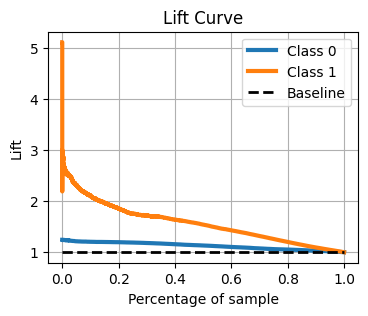

In [35]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('61_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [36]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [37]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('61_REPORT_importance_gain.csv'), index=True)

In [38]:
feat_impgain.head()

,importance
urban_flag,605.569275
NC__0.0,134.410843
LowDoc,132.427017
NC__8.0,99.735306
NC__2.0,98.541359


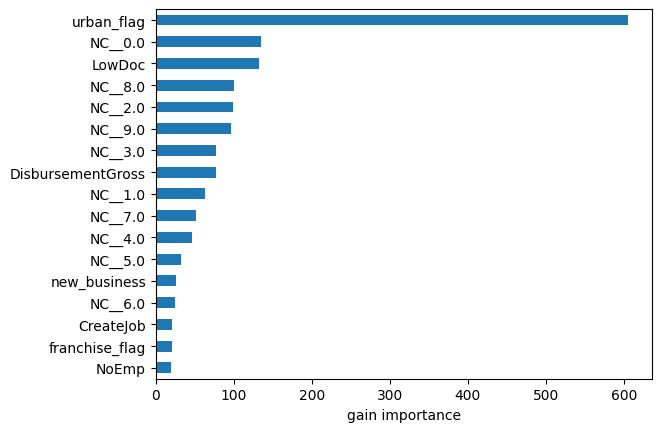

In [39]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('61_PLOT_importance_gain.png'))

##### Permutation Importance

In [40]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [41]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [42]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.069518,0.069518
5,urban_flag,0.043291,0.043291
7,NC__0.0,0.042511,0.042511
15,NC__8.0,0.025705,0.025705
1,CreateJob,0.021925,0.021925


In [43]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('61_DATA_importance_perturb.csv'),
            index=False)

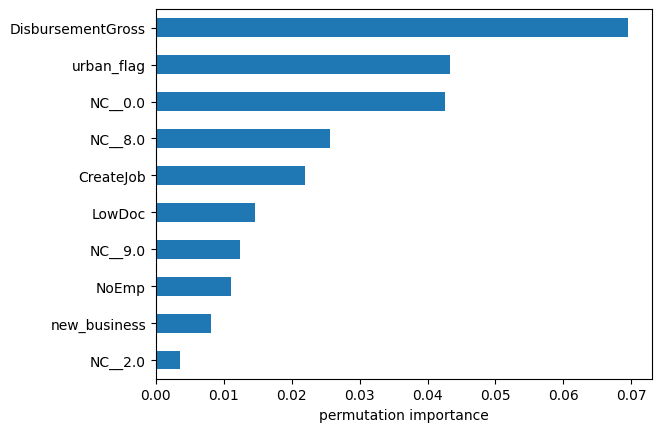

In [44]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('61_PLOT_importance_perturb.png'))

## PDP Plot - One Hot

In [45]:
naics_features = list(train_df.filter(like='NC_').columns)

In [46]:
plt.close()

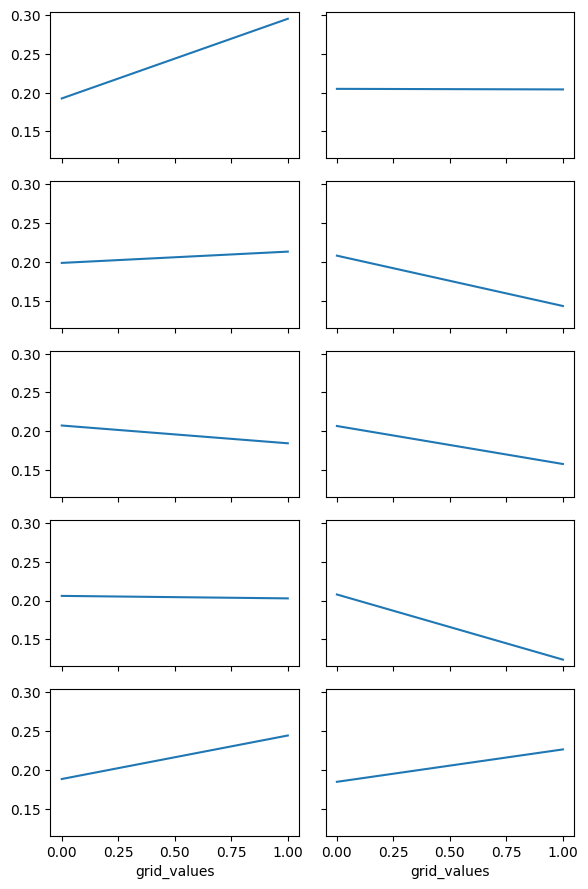

In [47]:
fig, ax = plt.subplots(int(np.ceil(len(naics_features)/2)), 2, sharex=True, sharey=True, figsize=(6, 9))
for i in range(len(naics_features)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    results = partial_dependence(xgb_model, train_df[predictor_features], 
                                 [naics_features[i]])
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('61_PLOT_pdp_naics_onehot.png'),
               bbox_inches='tight')
plt.show()